<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/13-transfer-learning/01_transfer_learning_with_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Transfer learning with image

The idea behind transfer learning is
that if someone has gone through the effort of training a big model on a bunch of data,
you can probably use that already trained model as a starting point for your problem.

Transfer learning works best when there are intrinsic similarities between the original
larger set of data and the smaller target data you want to apply it to.

Essentially, we want to transfer things we have learned
about one domain to a different, but related, domain. This is the idea behind transfer
learning.



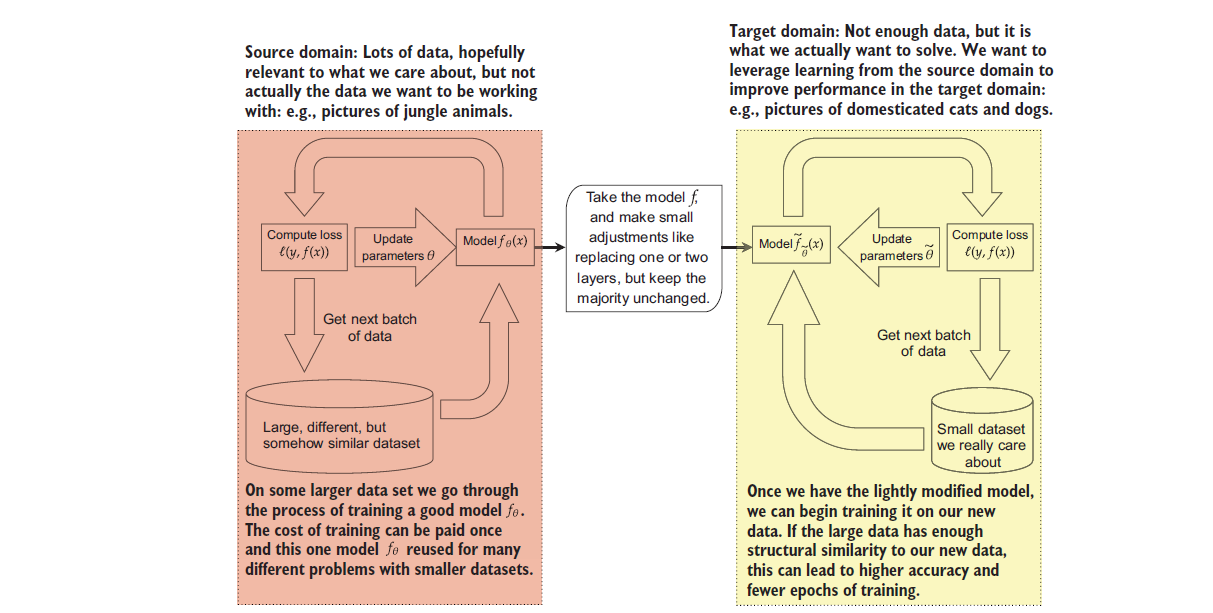

One of the most successful approaches to transfer learning that we learn to transfer the weights $w_{\theta}$ from one model to another. The original model is
trained on a large dataset of high-quality data, which shares some structural similarities
with the smaller set of data that we really care about.

In particular, we use the smaller ResNet architecture as our starting
point.

The left side shows a summary of ResNet. We want to alter it to look like the right side,
where only the last `nn.Linear` layer has been changed. The input to each `nn.Linear` layer is 512
because the final convolutional layer has `C = 512` channels, and using adaptive average pooling down to
just `1 x 1` means there are only 512 values in the output, regardless of the size of the original image.

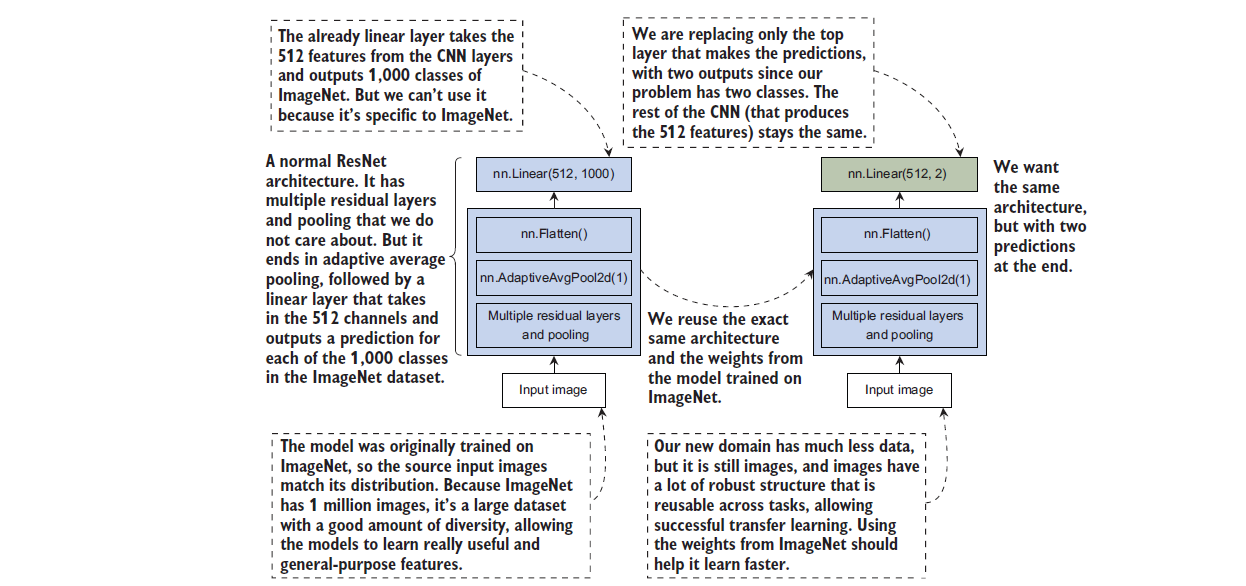

##Setup

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
import math
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

from idlmam import set_seed

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from idlmam import LastTimeStep, train_network, Flatten, weight_reset, View, LambdaLayer
from idlmam import AttentionAvg, GeneralScore, DotScore, AdditiveAttentionScore, getMaskByFill

import os
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import re

In [ ]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [4]:
torch.backends.cudnn.deterministic=True
set_seed(42)

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
import warnings
warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)

In [7]:
!mkdir -p data

In [8]:
data_zip_url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"

#Download this dataset if we have not already done so! 
if not os.path.isdir('data/PetImages'):
    resp = urlopen(data_zip_url)
    zipfile = ZipFile(BytesIO(resp.read()))
    zipfile.extractall(path = './data')

#This file is bad and will screw up the data loader! 
bad_files = [
    'data/PetImages/Dog/11702.jpg',
    "data/PetImages/Cat/666.jpg"
]
for f in bad_files:
    if os.path.isfile(f):
        os.remove(f)

##Cats-vs-Dogs dataset

In [9]:
# let’s create dataset using ImageFolder class
all_images = torchvision.datasets.ImageFolder("data/PetImages", transform=transforms.Compose(
  [
    transforms.Resize(120),     # The smallest of width/height will become 130 pixels
    transforms.CenterCrop(128), # Take the center 128 x 128 image
    transforms.ToTensor()       # Convert to a PyTorch tensor
  ]
))

train_size = int(len(all_images) * 0.8)   # Pick 80% for training
test_size = len(all_images) - train_size  # 20% remainder for testing

# Creates the random splits of the specified sizes
train_data, test_data = torch.utils.data.random_split(all_images, (train_size, test_size))

In [10]:
# we can now create DataLoaders for training and testing
B = 128
train_loader = DataLoader(train_data, batch_size=B, shuffle=True)
test_loader = DataLoader(test_data, batch_size=B)

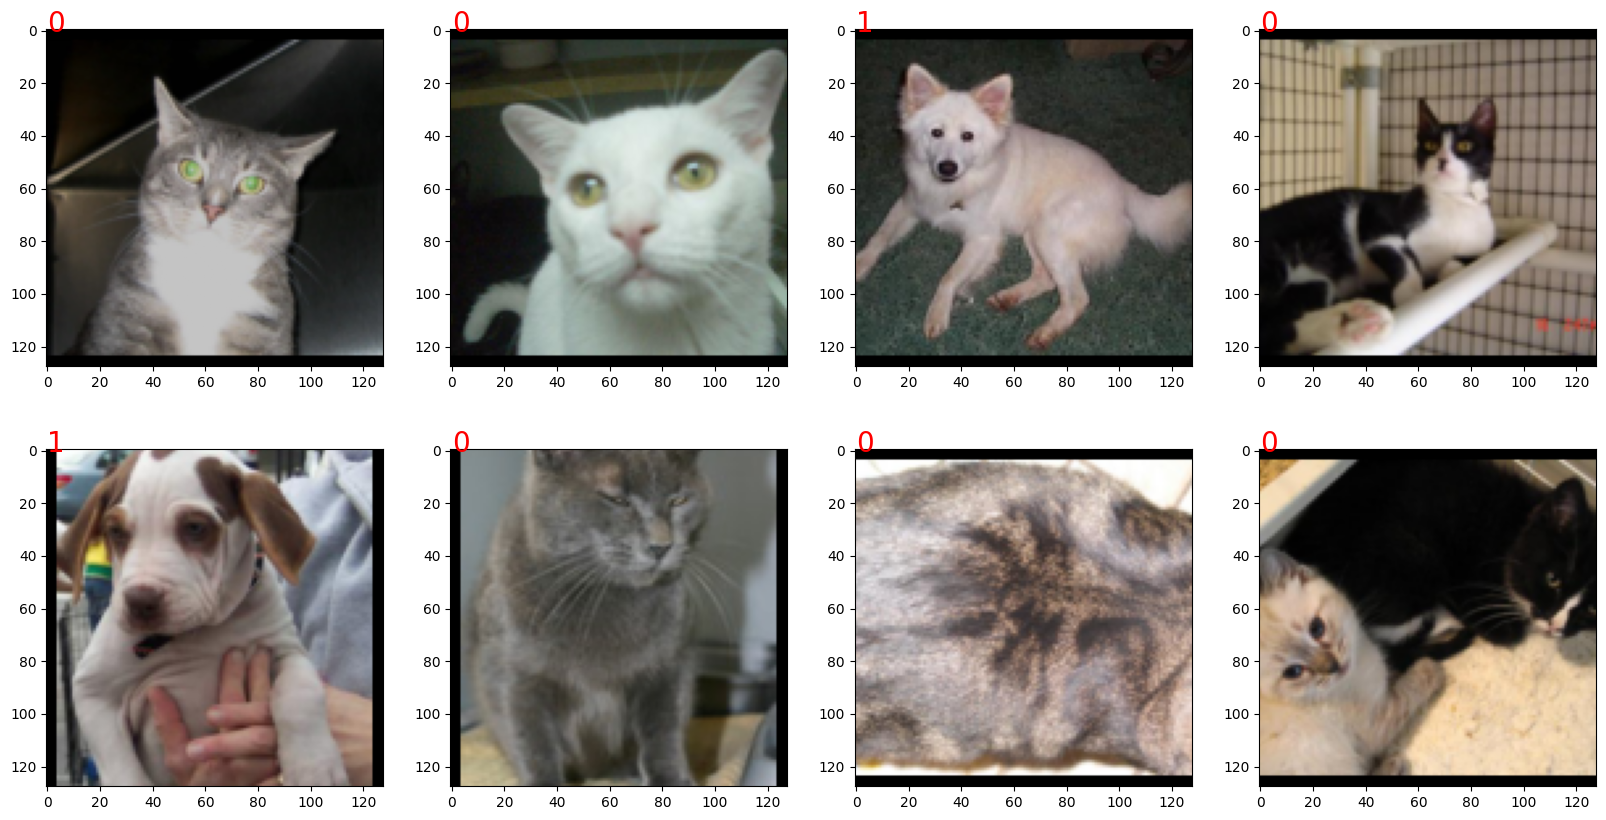

In [11]:
# let’s take a look at the data
f, axarr = plt.subplots(2, 4, figsize=(20, 10)) #Create a grid of 8 images (2 x 4)
for i in range(2):   # Rows
  for j in range(4): # Columns
    x, y = test_data[i*4+j] # Grab an image from the test corpus
    axarr[i,j].imshow(x.numpy().transpose(1,2,0)) #Plot the image 
    axarr[i,j].text(0.0, 0.5, str(round(y,2)), dict(size=20, color='red')) #Draw the label in the top left corner.

##Pretrained model

By default, the ResNet model has
random weights, so this is basically giving us a new ResNet to train from scratch for our
problem.

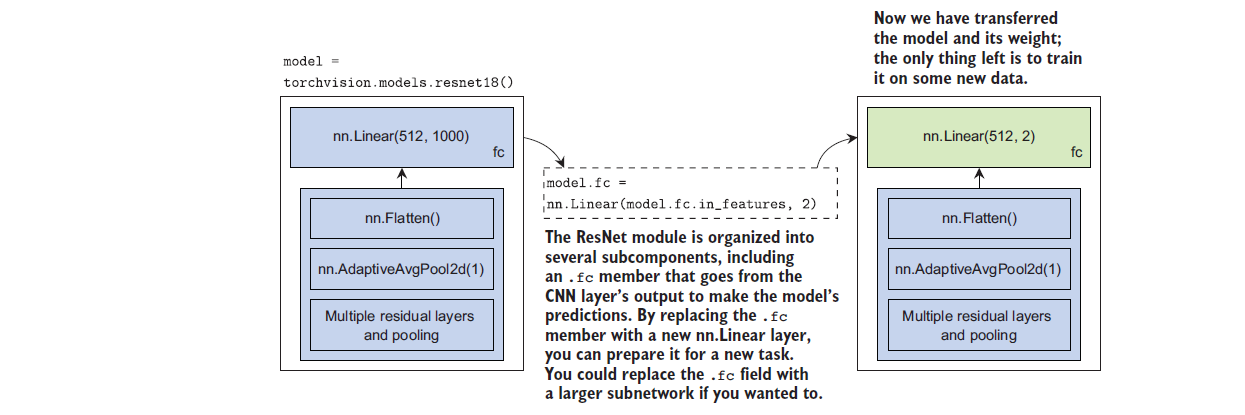

In [13]:
model = torchvision.models.resnet18()

In [15]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [16]:
# We are going to perfrom some "surgery"
model.fc = nn.Linear(model.fc.in_features, 2)
model.fc

Linear(in_features=512, out_features=2, bias=True)

Now, we can train this model to predict whether an image is of a cat or a dog.

In [ ]:
loss = nn.CrossEntropyLoss()

normal_results = train_network(model, 
                              loss, 
                              train_loader, 
                              val_loader=test_loader, 
                              score_funcs={'Accuracy': accuracy_score}, 
                              device=device, epochs=10)

<Axes: xlabel='epoch', ylabel='val Accuracy'>

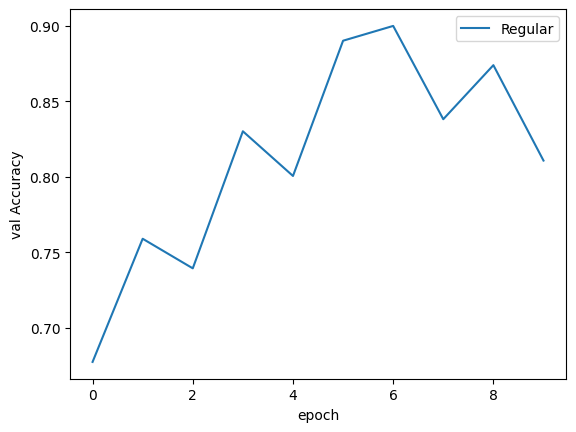

In [18]:
sns.lineplot(x="epoch", y="val Accuracy", data=normal_results, label="Regular")

##Adjusting pretrained networks(Fine-tuning)